In [1]:
!git clone https://github.com/Hannibal96/ImageCaptionProject.git

Cloning into 'ImageCaptionProject'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 202 (delta 116), reused 100 (delta 37), pack-reused 0
Receiving objects: 100% (202/202), 8.90 MiB | 23.07 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd ImageCaptionProject/

/content/ImageCaptionProject


In [4]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


In [5]:
from data import *

In [6]:
from models import *

In [16]:
from data import *
from models import *
import torchvision.transforms as T
from torchtext.vocab import GloVe # for pretrained model
import torch.optim as optim
from torch.utils.data import DataLoader
import pickle
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

def save_model(model, num_epochs):
    path = "caption_model_E_"+str(num_epochs)+".torch"
    torch.save(model, path)


def evaluate(model, val_data_set):
    blew_score = 0
    total_val_loss = 0

    with torch.no_grad():
        for idx, (image, captions) in tqdm(enumerate(iter(val_data_set))):
            image, captions = image.to(device), captions.to(device)

            all_captions = val_dataset.get_last_captions()
            features = model.encoder(image[0:1].to(device))
            caps, alphas = model.decoder.generate_caption(features, vocab=vocab)
            hyp_caption = ' '.join(caps)
            curr_blew_score = sentence_bleu(references=all_captions, hypothesis=hyp_caption.split())
            blew_score += curr_blew_score

            outputs, attentions = model(image, captions)
            outputs = outputs.to(device)
            targets = captions[:, 1:]
            targets = targets.to(device)
            val_loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            total_val_loss += val_loss.item()

    perplexity = total_val_loss / len(val_data_set)
    perplexity = np.exp(perplexity)
    return blew_score / len(val_data_set), total_val_loss/len(val_data_set), perplexity



In [ ]:
!ls 

In [12]:


images_path = '/content/drive/MyDrive/ImageCaption/Images'
captions_file_path = "captions.txt"
karpathy_json_path = 'Karpathy_data.json'

# define the transforms to be applied which needed for the pretrained CNN
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

#build vocab
vocab = build_vocab(captions_file_path=captions_file_path)

#build datasets
train, val, test = karpathy_split(captions_file_path, karpathy_json_path)
train_dataset = FlickrDataset(root_dir=images_path,vocab= vocab, captions_df=train,transform=transforms)
val_dataset = FlickrDataset(root_dir=images_path,vocab= vocab, captions_df=val,transform=transforms)
test_dataset = FlickrDataset(root_dir=images_path,vocab= vocab, captions_df=test,transform=transforms)
print("Finished building the Datasets.")

# Hyperparams
weights_matrix = None
# load pretrained embeddings (to train embeddings from scrach just set the embed_size)
#g = GloVe(name ='6B', dim=100)
embed_size = 300#g.dim
#weights_matrix = load_embedding_weights(vocab, g)

vocab_size = len(vocab)
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512
learning_rate = 3e-4
BATCH_SIZE = 32

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# init model
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size=vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim,
    embedding_weights = weights_matrix
).to(device)

pad_idx = vocab.stoi["<PAD>"]
train_data = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0,
                        shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True))
val_data = DataLoader(dataset=val_dataset, batch_size=1, num_workers=0,
                      shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True))

criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10
print_every = 1000


100%|██████████| 40455/40455 [00:02<00:00, 18195.76it/s]


Finished building the Datasets.


In [20]:
def train_one_epoch(model, train_data):
  total_loss = 0
  for idx, (image, captions) in tqdm(enumerate(iter(train_data))):
      image, captions = image.to(device), captions.to(device)

      # Zero the gradients.
      optimizer.zero_grad()

      # Feed forward
      outputs, attentions = model(image, captions)
      outputs = outputs.to(device)

      # Calculate the batch loss.
      targets = captions[:, 1:]
      targets = targets.to(device)
      loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

      # Backward pass.
      loss.backward()

      # Update the parameters in the optimizer.
      optimizer.step()

      total_loss += loss.item()
    
  return total_loss/len(train_data)

In [17]:
len(train_data)

938

Streaming output truncated to the last 5000 lines.

1667it [01:43, 15.54it/s]


1669it [01:43, 15.47it/s]


1671it [01:43, 15.47it/s]


1673it [01:43, 16.02it/s]


1675it [01:43, 15.88it/s]


1677it [01:43, 16.26it/s]


1679it [01:43, 15.48it/s]


1681it [01:43, 15.73it/s]


1683it [01:44, 15.67it/s]


1685it [01:44, 16.15it/s]


1687it [01:44, 15.95it/s]


1689it [01:44, 16.15it/s]


1691it [01:44, 16.32it/s]


1693it [01:44, 16.48it/s]


1695it [01:44, 16.14it/s]


1697it [01:44, 16.26it/s]


1699it [01:45, 15.94it/s]


1701it [01:45, 16.23it/s]


1703it [01:45, 16.01it/s]


1705it [01:45, 15.93it/s]


1707it [01:45, 16.24it/s]


1709it [01:45, 16.51it/s]


1711it [01:45, 16.69it/s]


1713it [01:45, 16.68it/s]


1715it [01:46, 16.42it/s]


1717it [01:46, 16.24it/s]


1719it [01:46, 16.54it/s]


1721it [01:46, 15.99it/s]


1723it [01:46, 16.18it/s]


1725it [01:46, 16.51it/s]


1727it [01:46, 16.57it/s]


1729it [01:46, 16.15it/s]


1731it [01:47, 16.76it/s]


1733it [01:47, 17.04it/s

Epoch: 10 loss: 2.613, perplexity: 13.637, BLEU: 0.450


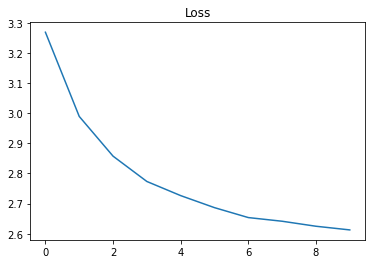

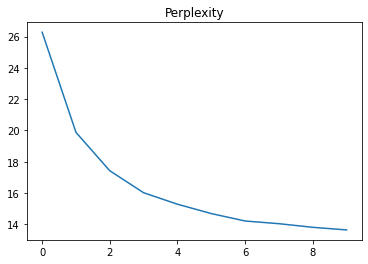

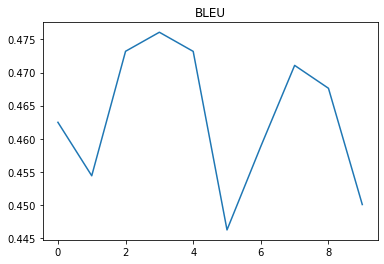

In [21]:
loss_list = []
perplexity_list = []
bleu_list = []
total_loss = 0
for epoch in range(1, num_epochs + 1):
    model.train()
    avg_training_loss = train_one_epoch(model, train_data)
    print('average loss = {}'.format(avg_training_loss))
    save_model(model, epoch)

    model.eval()
    bleu, loss, perp = evaluate(model, val_data)
    print("Epoch: {} loss: {:.3f}, perplexity: {:.3f}, BLEU: {:.3f}".format(epoch, loss, perp, bleu))
    perplexity_list.append(perp)
    loss_list.append(loss)
    bleu_list.append(bleu)

    pickle.dump(perplexity_list, open('perplexity_list.p', 'wb'))
    pickle.dump(loss_list, open('loss_list.p', 'wb'))
    pickle.dump(bleu_list, open('blew_list.p', 'wb'))


plt.plot(loss_list)
plt.title('Loss')
plt.show()

plt.plot(perplexity_list)
plt.title('Perplexity')
plt.show()

plt.plot(bleu_list)
plt.title('BLEU')
plt.show()

In [ ]:
# Evaluate on test data:
model.eval()
test_data = DataLoader(dataset=test_dataset, batch_size=1, num_workers=0,
                      shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True))
bleu, loss, perp = evaluate(model, test_data)

In [23]:
bleu

0.607170737194971

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


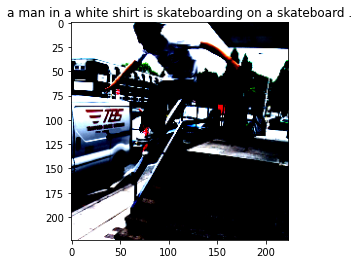

true captions
a boy wearing a white shirt and pink shoelaces jumping on a railing
A man jumps of the handrail of an outdoor staircase .
A person on a skateboard .
A skateboarder is balancing on the rail of stairs .
A teenage boy jumps off a rail .


In [43]:
with torch.no_grad():
  dataiter = iter(test_data)
  img, true_captions = next(dataiter)
  caps_true = test_dataset.get_last_captions()
  features = model.encoder(img[0:1].to(device))
  caps, alphas = model.decoder.generate_caption(features, vocab=vocab)
  hyp_caption = ' '.join(caps[:-1])
  show_image(img[0], title=hyp_caption)
  print('true captions')
  for i in range(5):
    print(' '.join(caps_true[i]))

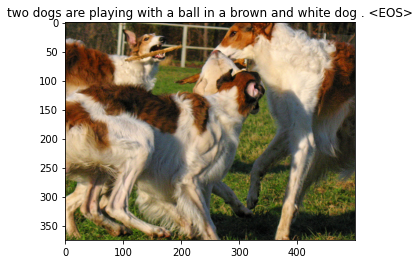

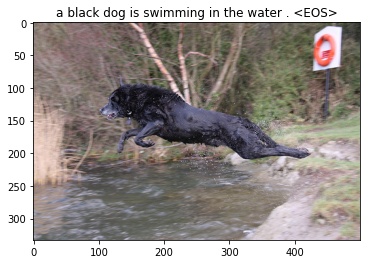

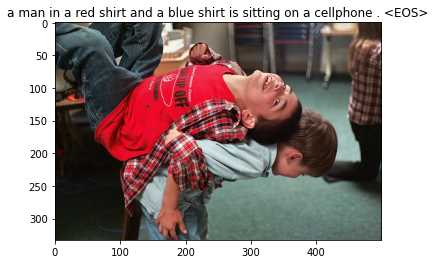

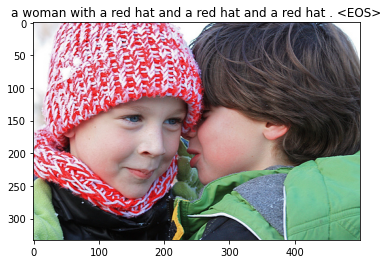

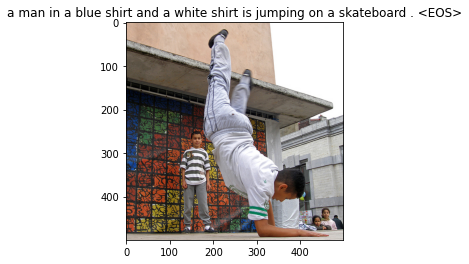

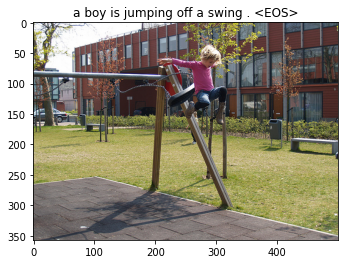

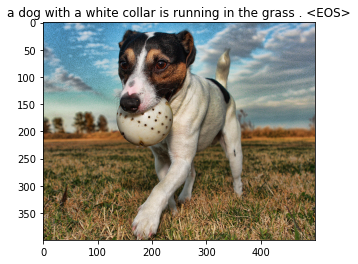

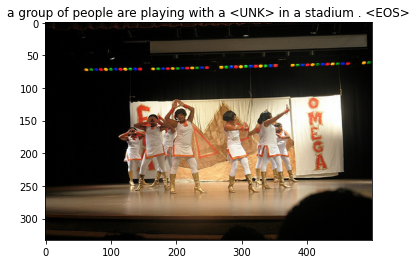

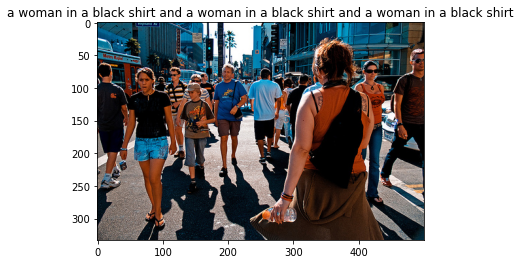

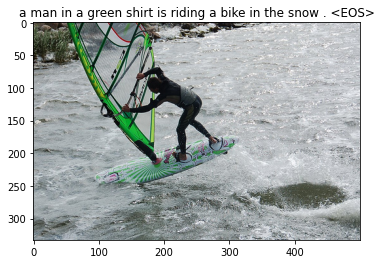

In [67]:
idxs = np.random.randint(size=10,low=0, high=4999)
for idx in idxs:
  im = Image.open(images_path +'/'+ test_dataset.imgs[idx])
  plt.imshow(im)
  img = transforms(im).unsqueeze(0)
  features = model.encoder(img.to(device))
  caps, alphas = model.decoder.generate_caption(features, vocab=vocab)
  plt.title(' '.join(caps))
  plt.show()

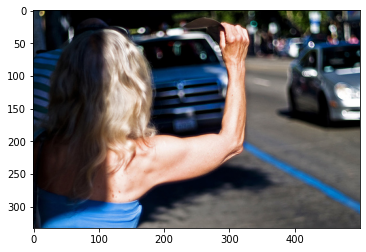

In [48]:
plt.imshow(im)

In [55]:
img = transforms(im).unsqueeze(0)

In [57]:
features = model.encoder(img.to(device))

In [59]:
caps, alphas = model.decoder.generate_caption(features, vocab=vocab)

In [60]:
caps

['a',
 'girl',
 'in',
 'a',
 'blue',
 'shirt',
 'is',
 'playing',
 'with',
 'a',
 'blue',
 'toy',
 '.',
 '<EOS>']

In [65]:
sentence_bleu??